https://github.com/adeshpande3/LSTM-Sentiment-Analysis

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.contrib import rnn

## Read pre-trained word vectors

https://nlp.stanford.edu/projects/glove/

In [2]:
vocab_size = 400000
embed_size = 50

wordVectors = np.random.normal(0, size=[vocab_size, embed_size])
wordVectors = wordVectors.astype(np.float32) ## to be consistent
wordsList = []

with open('glove.6B.50d.txt', encoding="utf-8", mode="r") as textFile:
    word_id = 0
    for line in textFile:
        line = line.split()
        #format of line: word, v1, v2, ..., v5
        word = line[0]
        wordsList.append(word)
        wordVectors[word_id] = np.array(line[1:], dtype=np.float32)
        word_id += 1;

In [3]:
print('Shape of Word Vector: ', wordVectors.shape)
print('Embedding vector of first word: ',wordVectors[0][:5], '...')
print('The index of word `good` is: ', wordsList.index('good'))

Shape of Word Vector:  (400000, 50)
Embedding vector of first word:  [ 0.41800001  0.24968    -0.41242     0.1217      0.34527001] ...
The index of word `good` is:  219


### An example of sentence coding

![](https://github.com/adeshpande3/LSTM-Sentiment-Analysis/raw/4bb7b1e8c0e8e9f7f649d1f68cb34db0b2b6675e/Images/SentimentAnalysis5.png)

In [4]:
maxSeqLength = 10 #Maximum length of sentence
numDimensions = embed_size #Dimensions for each word vector
firstSentence = np.zeros((maxSeqLength), dtype='int32')
firstSentence[0] = wordsList.index("i")
firstSentence[1] = wordsList.index("thought")
firstSentence[2] = wordsList.index("the")
firstSentence[3] = wordsList.index("movie")
firstSentence[4] = wordsList.index("was")
firstSentence[5] = wordsList.index("incredible")
firstSentence[6] = wordsList.index("and")
firstSentence[7] = wordsList.index("inspiring")
print(firstSentence) #Shows the row index for each word

[   41   804     0  1005    15  7446     5 13767     0     0]


In [5]:
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(wordVectors,firstSentence).eval().shape)

(10, 50)


## Read in comments

### Investigate length of comments to determine sequence length

In [6]:
from os import listdir
from os.path import isfile, join
positiveFiles = ['positiveReviews/' + f for f in listdir('positiveReviews/') if isfile(join('positiveReviews/', f))]
negativeFiles = ['negativeReviews/' + f for f in listdir('negativeReviews/') if isfile(join('negativeReviews/', f))]
numWords = []
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

Positive files finished
Negative files finished
The total number of files is 25000
The total number of words in the files is 5844680
The average number of words in the files is 233.7872


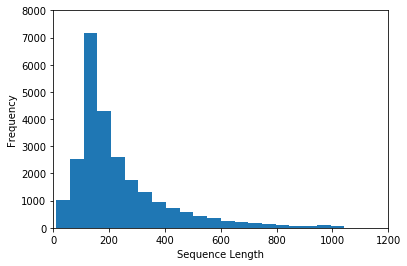

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

*Assign Sequence Length*

In [8]:
maxSeqLength = 250

### Example of translating

*Before cleaning, raw text*

In [9]:
fname = positiveFiles[3] #Can use any valid index (not just 3)
with open(fname) as f:
    for lines in f:
        print(lines)
        exit

This is easily the most underrated film inn the Brooks cannon. Sure, its flawed. It does not give a realistic view of homelessness (unlike, say, how Citizen Kane gave a realistic view of lounge singers, or Titanic gave a realistic view of Italians YOU IDIOTS). Many of the jokes fall flat. But still, this film is very lovable in a way many comedies are not, and to pull that off in a story about some of the most traditionally reviled members of society is truly impressive. Its not The Fisher King, but its not crap, either. My only complaint is that Brooks should have cast someone else in the lead (I love Mel as a Director and Writer, not so much as a lead).


*After cleaning*

In [10]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

with open(fname) as f:
    for lines in f:
        print(cleanSentences(lines))
        exit

this is easily the most underrated film inn the brooks cannon sure its flawed it does not give a realistic view of homelessness unlike say how citizen kane gave a realistic view of lounge singers or titanic gave a realistic view of italians you idiots many of the jokes fall flat but still this film is very lovable in a way many comedies are not and to pull that off in a story about some of the most traditionally reviled members of society is truly impressive its not the fisher king but its not crap either my only complaint is that brooks should have cast someone else in the lead i love mel as a director and writer not so much as a lead


*After encoding*

In [11]:
firstFile = np.zeros((maxSeqLength), dtype='int32')
with open(fname) as f:
    indexCounter = 0
    line=f.readline()
    cleanedLine = cleanSentences(line)
    split = cleanedLine.split()
    for word in split:
        if indexCounter < maxSeqLength:
            try:
                firstFile[indexCounter] = wordsList.index(word)
            except ValueError:
                firstFile[indexCounter] = 399999 #Vector for unknown words
        indexCounter = indexCounter + 1
firstFile

array([   37,    14,  2407,     0,    96, 37314,   319,  7158,     0,
        6469,  8828,  1085,    47,  9703,    20,   260,    36,   455,
           7,  7284,  1139,     3, 26494,  2633,   203,   197,  3941,
       12739,   646,     7,  7284,  1139,     3, 11990,  7792,    46,
       12608,   646,     7,  7284,  1139,     3,  8593,    81, 36381,
         109,     3,     0,  8735,   807,  2983,    34,   149,    37,
         319,    14,   191, 31906,     6,     7,   179,   109, 15402,
          32,    36,     5,     4,  2933,    12,   138,     6,     7,
         523,    59,    77,     3,     0,    96,  4246, 30006,   235,
           3,   908,    14,  4702,  4571,    47,    36,     0,  6429,
         691,    34,    47,    36, 35404,   900,   192,    91,  4499,
          14,    12,  6469,   189,    33,  1784,  1318,  1726,     6,
           0,   410,    41,   835, 10464,    19,     7,   369,     5,
        1541,    36,   100,   181,    19,     7,   410,     0,     0,
           0,     0,

### Load previous results (skipped some processing codes here)

In [12]:
ids = np.load('idsMatrix.npy')
ids[3]

array([    37,     14,   2407, 201534,     96,  37314,    319,   7158,
       201534,   6469,   8828,   1085,     47,   9703,     20,    260,
           36,    455,      7,   7284,   1139,      3,  26494,   2633,
          203,    197,   3941,  12739,    646,      7,   7284,   1139,
            3,  11990,   7792,     46,  12608,    646,      7,   7284,
         1139,      3,   8593,     81,  36381,    109,      3, 201534,
         8735,    807,   2983,     34,    149,     37,    319,     14,
          191,  31906,      6,      7,    179,    109,  15402,     32,
           36,      5,      4,   2933,     12,    138,      6,      7,
          523,     59,     77,      3, 201534,     96,   4246,  30006,
          235,      3,    908,     14,   4702,   4571,     47,     36,
       201534,   6429,    691,     34,     47,     36,  35404,    900,
          192,     91,   4499,     14,     12,   6469,    189,     33,
         1784,   1318,   1726,      6, 201534,    410,     41,    835,
      

### Define functions to get batch of train samples with half positive and half negative

In [13]:
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,11499)
            labels.append([1,0])
        else:
            num = randint(13499,24999)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(11499,13499)
        if (num <= 12499):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

### Example of a batch

In [14]:
batchSize = 10
arr_labels = getTrainBatch()
print('Length of x1, ', len(arr_labels[0][0])) # Shape of arr is [batch_size, max_sequence]
print('Length of x2, ', len(arr_labels[0][1])) # Shape of arr is [batch_size, max_sequence]
print('...Batch size')
print('Y, ', arr_labels[1])

Length of x1,  250
Length of x2,  250
...Batch size
Y,  [[1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1]]


# 1. Define LSTM model

![](https://github.com/adeshpande3/LSTM-Sentiment-Analysis/raw/4bb7b1e8c0e8e9f7f649d1f68cb34db0b2b6675e/Images/SentimentAnalysis16.png)

In [15]:
batchSize = 24
lstmUnits = 64
n_classes = 2
iterations = 100  # 100000
learning_rate = 0.001

### Transform input

In [16]:
x = tf.placeholder(tf.int32,[batchSize, maxSeqLength]) # Note it is consistent with `arr` from next_batch function
y = tf.placeholder(tf.int32,[batchSize, n_classes]) # Note it is consistent with `label` from next_batch function

In [27]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32) # the vector after embedding
data = tf.nn.embedding_lookup(wordVectors, x) # pay attention to the shape of `x` and `data`
data = tf.unstack(data, maxSeqLength, 1) # https://www.tensorflow.org/api_docs/python/tf/unstack 

In [18]:
print('Length:', len(data), ', Element:', data[0])
print() 
# maxSeqLength * [batch_size, numDimensions]
# time_steps * [batch_size, n_input]

Length: 250 , Element: Tensor("unstack:0", shape=(24, 50), dtype=float32)



### Main Model

Just a typical single layer LSTM

In [19]:
lstmCell = rnn.BasicLSTMCell(lstmUnits)
lstmCell = rnn.DropoutWrapper(cell = lstmCell, output_keep_prob = 0.75)
outputs, _ = tf.nn.static_rnn(lstmCell, data, dtype= tf.float32)

In [20]:
out_weights = tf.Variable(tf.random_normal([lstmUnits, n_classes]))
out_bias = tf.Variable(tf.random_normal([n_classes]))
prediction = tf.matmul(outputs[-1], out_weights)+ out_bias
loss =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = prediction, labels = y))
opt = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
correctPred = tf.equal(tf.argmax(prediction, 1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

## Start Training

In [ ]:
# import datetime
# tf.summary.scalar('Loss', loss)
# tf.summary.scalar('Accuracy', accuracy)
# merged = tf.summary.merge_all()
# logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
# writer = tf.summary.FileWriter(logdir, sess.graph)

In [24]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

for i in range(iterations):
    #Next Batch of reviews
    nextBatch, nextBatchLabels = getTrainBatch();
    sess.run(opt, {x: nextBatch, y: nextBatchLabels})
   
    #Calculate training error 
    if (i % 10 == 0):
        acc=sess.run(accuracy,feed_dict={x:nextBatch, y:nextBatchLabels})
        los=sess.run(loss,feed_dict={x:nextBatch, y:nextBatchLabels})
        print('For iter ',i,', Accuracy: ', acc, ' ,Loss: ',los)

#     #Write summary to Tensorboard
#     if (i % 50 == 0):
#         summary = sess.run(merged, {x: nextBatch, y: nextBatchLabels})
#         writer.add_summary(summary, i)
        
#     #Save the network every 10,000 training iterations
#     if (i % 10000 == 0 and i != 0):
#         save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
#         print("saved to %s" % save_path)
#writer.close()

For iter  0 , Accuracy:  0.416667  ,Loss:  1.00945


### Apply to test dataset

In [23]:
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {x: nextBatch, y: nextBatchLabels})) * 100)

Accuracy for this batch: 37.5
Accuracy for this batch: 41.6666656733
Accuracy for this batch: 37.5
Accuracy for this batch: 45.8333343267
Accuracy for this batch: 29.1666656733
Accuracy for this batch: 58.3333313465
Accuracy for this batch: 62.5
Accuracy for this batch: 50.0
Accuracy for this batch: 50.0
Accuracy for this batch: 66.6666686535


## 2. Define CNN model

![example](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-8.03.47-AM-1024x413.png)

In [32]:
data_cnn = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32) # Same as LTSM
data_cnn = tf.nn.embedding_lookup(wordVectors, x)  # Same as LTSM
data_cnn = tf.reshape(data_cnn, [batchSize,maxSeqLength,numDimensions,1]) # Reshape to 3D, first 1 + 3d
data_cnn

<tf.Tensor 'Reshape_1:0' shape=(24, 250, 50, 1) dtype=float32>

In [ ]:
filter_size = 2 # Number of words per stride
num_filters = 4 # Number of filters, matching the figures
filter_shape = [filter_size, embed_size, 1, num_filters] # `1` is number of channels

In [44]:
W_conv1 = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters]))
h_conv1 = tf.nn.relu(tf.nn.conv2d(data_cnn, W_conv1, 
                                  strides=[1, 1, 1, 1], padding='VALID') + b_conv1) # Note, cannot use SAME
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, maxSeqLength - filter_size + 1, 1, 1], 
                         strides=[1, 1, 1, 1], padding='VALID')
h_pool1_flat = tf.reshape(h_pool1, [-1, num_filters])

In [58]:
h_conv1

<tf.Tensor 'Relu_4:0' shape=(24, 249, 1, 4) dtype=float32>

In [60]:
h_pool1

<tf.Tensor 'MaxPool_3:0' shape=(24, 1, 1, 4) dtype=float32>

In [45]:
h_pool1_flat

<tf.Tensor 'Reshape_2:0' shape=(24, 4) dtype=float32>

In [49]:
keep_prob_ = tf.placeholder(tf.float32)
h_pool1_flat_drop= tf.nn.dropout(h_pool1_flat, keep_prob_)

W_fc1 = tf.Variable(tf.truncated_normal([num_filters, n_classes], stddev= 0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape = [n_classes]))
prediction_ = tf.nn.relu(tf.matmul(h_pool1_flat_drop, W_fc1) + b_fc1) # use relu as activition function

In [54]:
h_pool1_flat_drop

<tf.Tensor 'dropout_1/mul:0' shape=(24, 4) dtype=float32>

In [51]:
loss_ = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = prediction_, labels = y))
opt_ = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss_)
correctPred_ = tf.equal(tf.argmax(prediction_, 1), tf.argmax(y,1))
accuracy_ = tf.reduce_mean(tf.cast(correctPred_, tf.float32))

In [57]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

for i in range(iterations):
    nextBatch, nextBatchLabels = getTrainBatch();
    sess.run(opt_, {x: nextBatch, y: nextBatchLabels, keep_prob_: 0.50})

    if (i % 10 == 0):
        acc_=sess.run(accuracy_,feed_dict={x:nextBatch, y:nextBatchLabels, keep_prob_: 1.00})
        los_=sess.run(loss_,feed_dict={x:nextBatch, y:nextBatchLabels, keep_prob_: 1.00})
        print('For iter ',i,', Accuracy: ', acc_, ' ,Loss: ',los_)

For iter  0 , Accuracy:  0.541667  ,Loss:  0.681307
For iter  10 , Accuracy:  0.625  ,Loss:  0.684197
For iter  20 , Accuracy:  0.541667  ,Loss:  0.690056
For iter  30 , Accuracy:  0.625  ,Loss:  0.690871
For iter  40 , Accuracy:  0.5  ,Loss:  0.697458
For iter  50 , Accuracy:  0.541667  ,Loss:  0.695283
For iter  60 , Accuracy:  0.5  ,Loss:  0.689254
For iter  70 , Accuracy:  0.5  ,Loss:  0.687342
For iter  80 , Accuracy:  0.458333  ,Loss:  0.697901
For iter  90 , Accuracy:  0.5  ,Loss:  0.695119


## 3. Combine CNN and LSTM

In [59]:
h_conv1

<tf.Tensor 'Relu_4:0' shape=(24, 249, 1, 4) dtype=float32>

In [69]:
h_pool2 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 1, 1], 
                         strides=[1, 2, 1, 1], padding='VALID')
h_pool2

<tf.Tensor 'MaxPool_7:0' shape=(24, 124, 1, 4) dtype=float32>

In [84]:
#goal: Length: 250 , Element: Tensor("unstack:0", shape=(24, 50), dtype=float32)
h_unstack = tf.unstack(h_pool2, axis = 3)
h_unstack

[<tf.Tensor 'unstack_7:0' shape=(24, 124, 1) dtype=float32>,
 <tf.Tensor 'unstack_7:1' shape=(24, 124, 1) dtype=float32>,
 <tf.Tensor 'unstack_7:2' shape=(24, 124, 1) dtype=float32>,
 <tf.Tensor 'unstack_7:3' shape=(24, 124, 1) dtype=float32>]

In [92]:
h_concat = tf.concat(h_unstack, axis = 2)
h_concat

<tf.Tensor 'concat_18:0' shape=(24, 124, 4) dtype=float32>

In [96]:
data_ = tf.unstack(h_concat, 124 , 1) # https://www.tensorflow.org/api_docs/python/tf/unstack 
print('Length:', len(data_), ', Element:', data_[0])
print() 

Length: 124 , Element: Tensor("unstack_11:0", shape=(24, 4), dtype=float32)



### Then follows the typical LSTM module